In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import numpy as np

In [2]:
data_dir = '/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_GSE135337/'
os.chdir(data_dir)

In [3]:
names_list = ["GSM4006644_BC1", "GSM4006647_BC4" ,"GSM4006648_BC5", "GSM4751267_BC6" ,"GSM4751268_BC7"]

GSM4006644_BC1


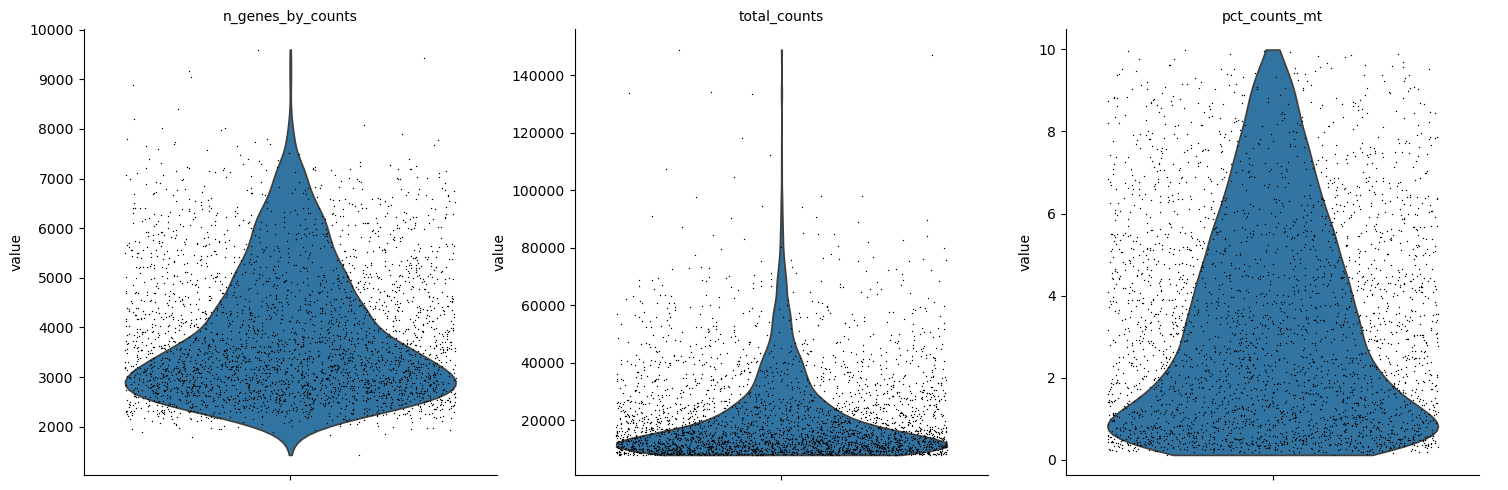

/tmp/ipykernel_1043649/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006647_BC4


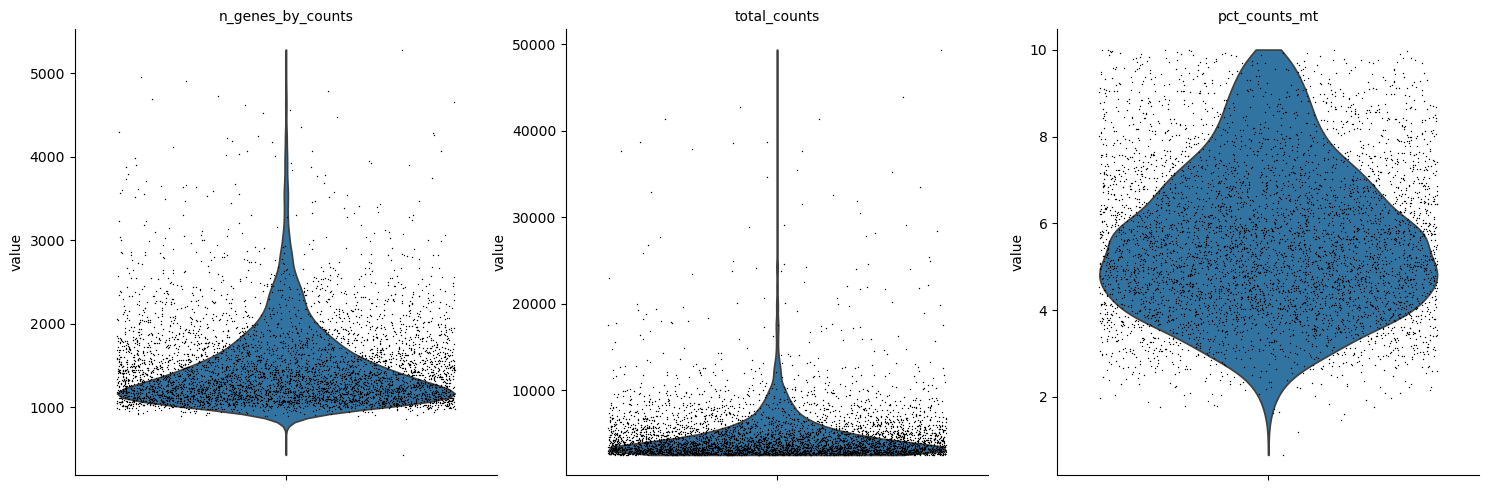

/tmp/ipykernel_1043649/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006648_BC5


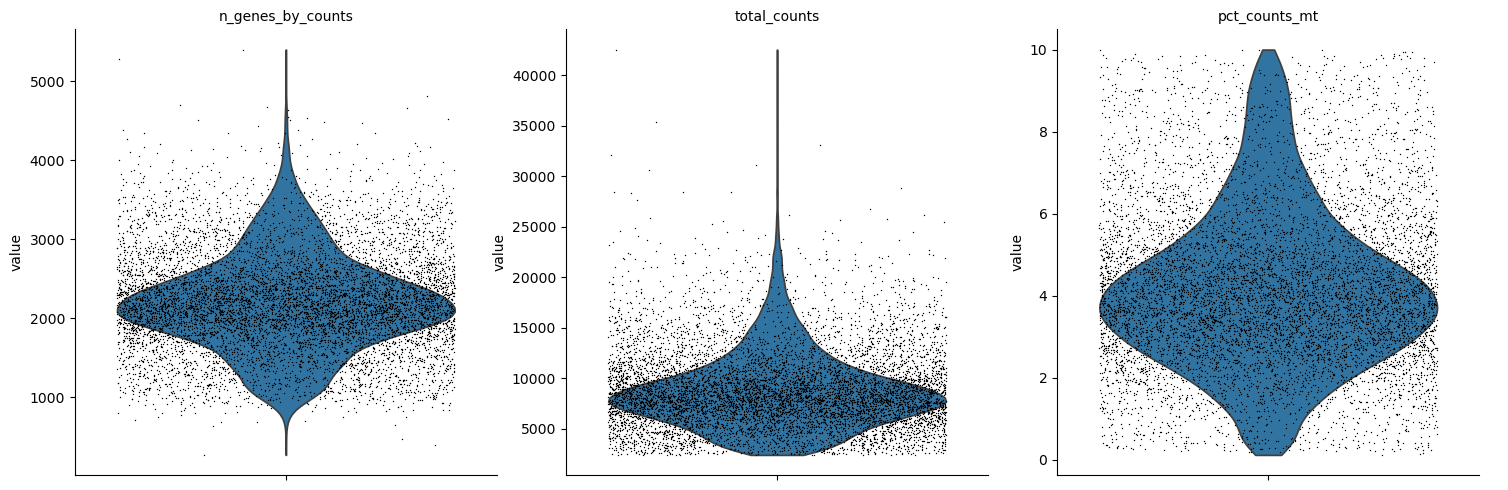

/tmp/ipykernel_1043649/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751267_BC6


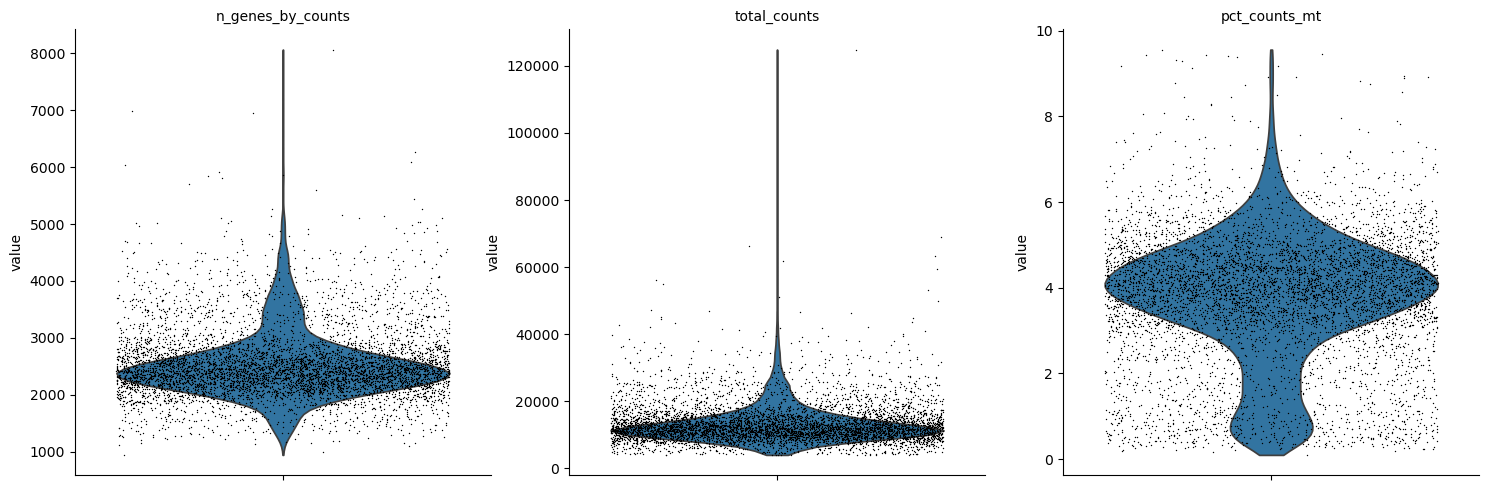

/tmp/ipykernel_1043649/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751268_BC7


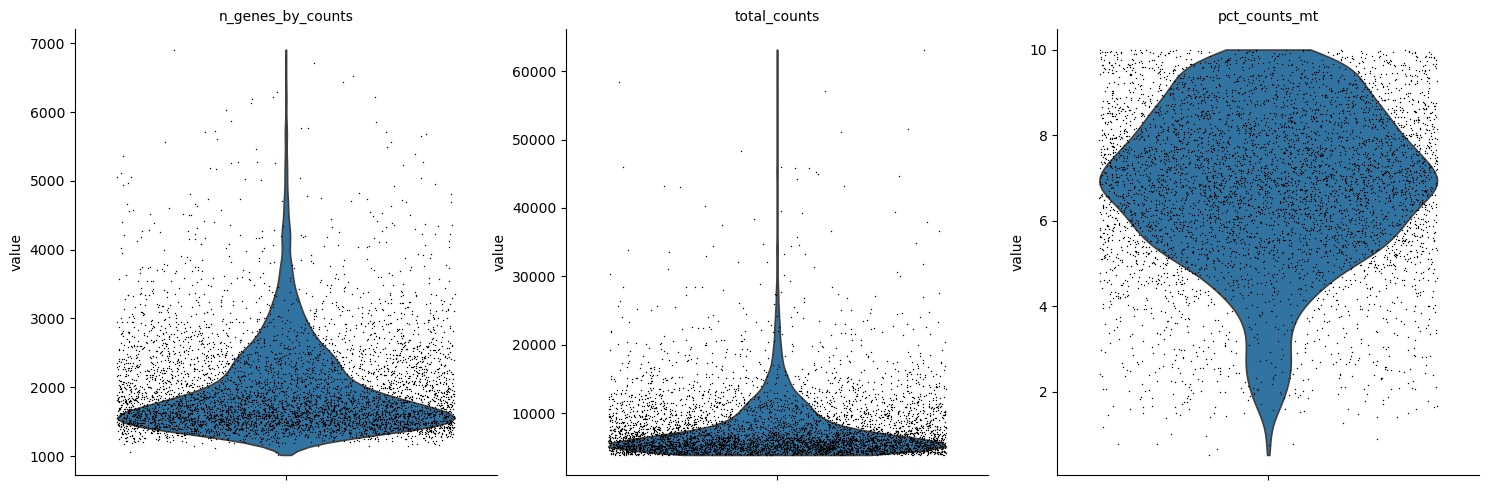

/tmp/ipykernel_1043649/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


In [4]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:
    file_path = f"{name}_gene_cell_exprs_table.txt.gz"
    df = pd.read_csv(file_path, sep='\t')
    df.index = df.iloc[:, 0]
    gene_symbols = df.iloc[:,:2]

    # Drop the first two columns (Ensembl ID and gene name)
    df = df.iloc[:, 2:]
    # Transpose so that cells are rows and genes are columns
    df = df.T

    adata = ad.AnnData(df)

    adata.obs['CellID']= df.index
    adata.var[['Ensemble_ID','Gene']]= gene_symbols
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 
    adata.var['mt'] =adata.var_names.str.startswith('MT-')

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    print(name)
    sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)
    
    adata= adata[adata.obs.n_genes_by_counts <6001, :]
    #adata= adata[adata.obs.pct_counts_mt< 5, :].copy()

    adata.obs['source'] = name
    adata.layers["counts"] = adata.X.copy()    

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata  # keep full dimension safe
    adata_list.append(adata)
    

In [5]:
batch_names = [adata.obs['source'].iloc[0] for adata in adata_list]
adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)                                  

/tmp/ipykernel_1043649/1379501109.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)


In [6]:
immune_remove = pd.read_pickle('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/immune_cells_obs.pkl')

In [11]:
adata_non_immune = adata[~adata.obs.index.isin(immune_remove.index),]

In [15]:
adata_non_immune

AnnData object with n_obs × n_vars = 27864 × 2000
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268_BC7', 'G

In [13]:
adata_non_immune.raw = adata_non_immune  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="source",
    subset=True,
)

In [25]:
import scvi
scvi.model.SCVI.setup_anndata(adata_non_immune, layer="counts", batch_key="source")

In [26]:
model = scvi.model.SCVI(adata_non_immune, n_layers=2, n_latent=30, gene_likelihood="nb")

In [17]:
model.train()

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bo

Training:   0%|          | 0/287 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=287` reached.


In [18]:
SCVI_LATENT_KEY = "X_scVI"
adata_non_immune.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [19]:
sc.pp.neighbors(adata_non_immune, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_non_immune,resolution=0.5)#,  random_state=0

/tmp/ipykernel_1043649/1145043127.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_non_immune,resolution=0.5)


In [21]:
adata_non_immune.write(os.path.join('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT','blca_nm_OUTPUT_non_immune_scvi.h5ad'), compression="gzip")

In [3]:
adata_non_immune = sc.read_h5ad('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_nm_OUTPUT_non_immune_scvi.h5ad')

In [4]:
adata_non_immune

AnnData object with n_obs × n_vars = 27864 × 2000
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM475126

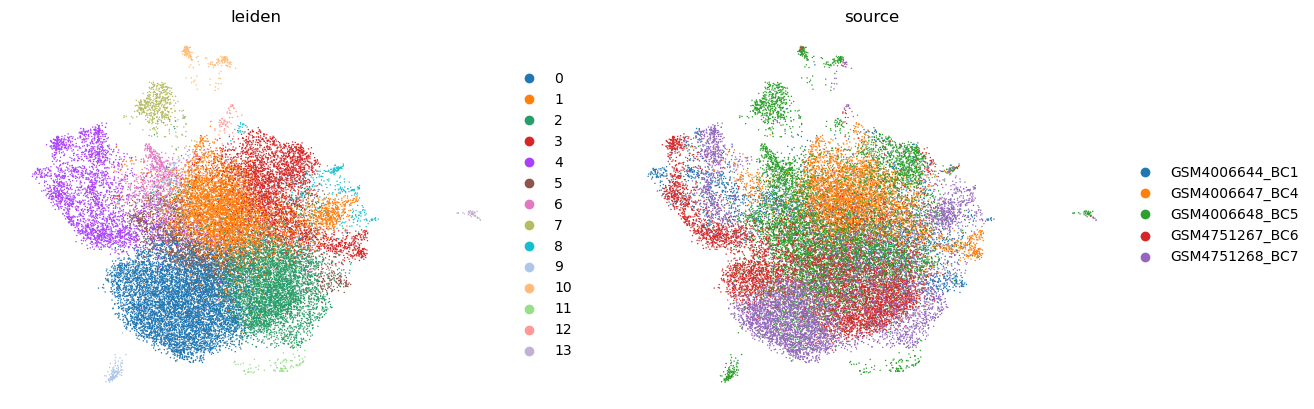

In [5]:
sc.tl.umap(adata_non_immune)#, min_dist=0.5)
sc.pl.umap(
    adata_non_immune,
    color=[ "leiden","source",],
    frameon=False,
    ncols=2,
)

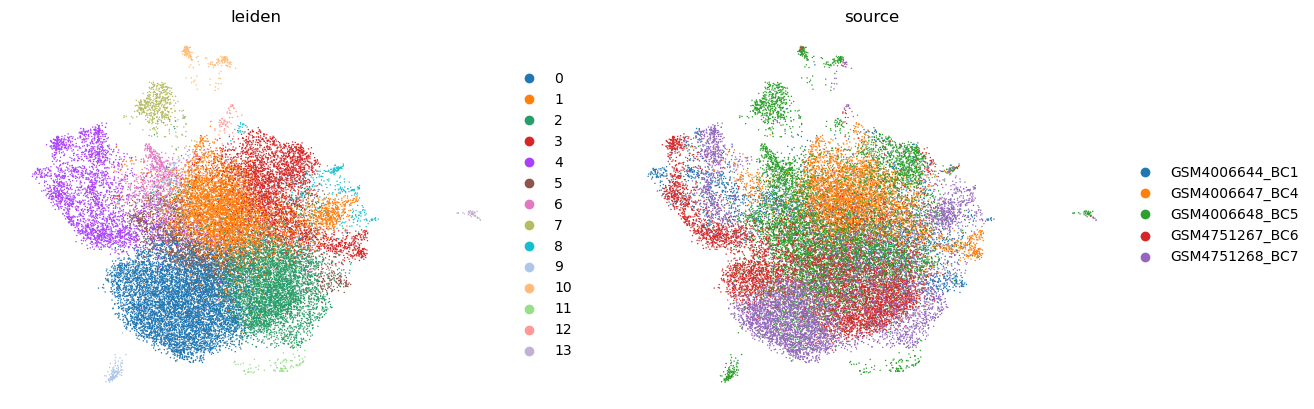

In [9]:
sc.tl.umap(adata_non_immune)#, min_dist=0.5)
sc.pl.umap(
    adata_non_immune,
    color=[ "leiden","source",],
    frameon=False,
    ncols=2,
)

In [6]:
adata_non_immune.obs['Stage'] = 'Ta'
adata_non_immune.obs.loc[adata_non_immune.obs['source'] == 'GSM4006647_BC4', 'Stage'] = 'T2'
adata_non_immune.obs.loc[adata_non_immune.obs['source'] == 'GSM4006648_BC5', 'Stage'] = 'T3'

In [7]:
set(adata_non_immune.obs['source'])

{'GSM4006644_BC1',
 'GSM4006647_BC4',
 'GSM4006648_BC5',
 'GSM4751267_BC6',
 'GSM4751268_BC7'}

In [9]:
adata_non_immune.obs.to_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/non_immune_cells_obs.csv')

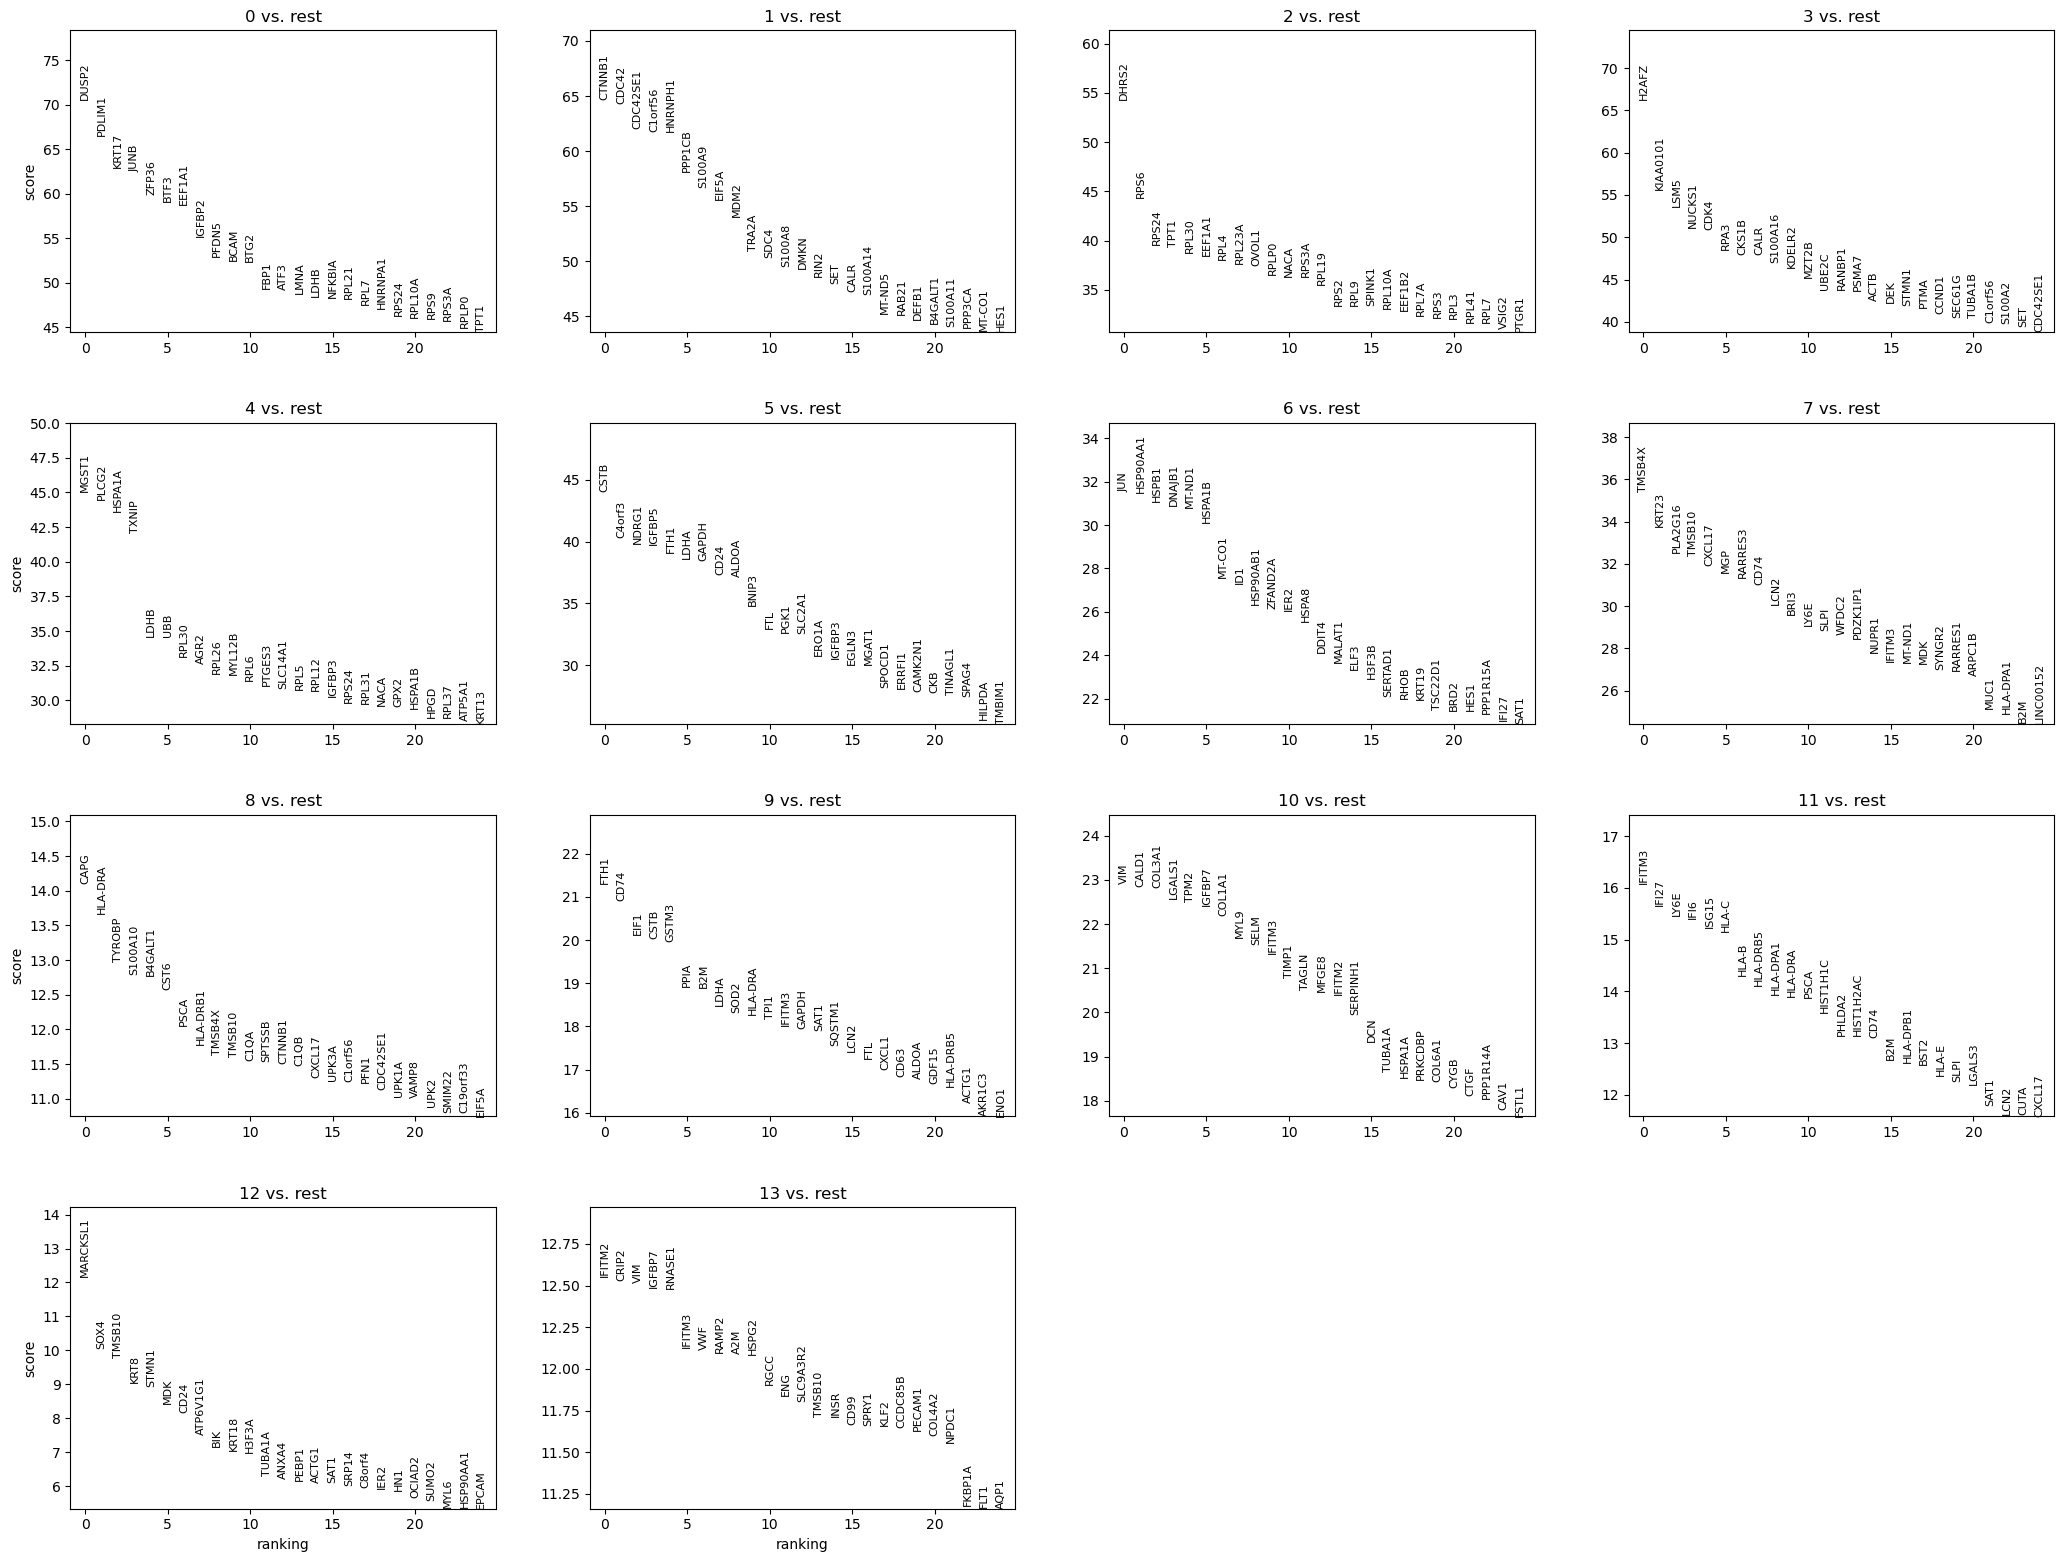

In [28]:
sc.tl.rank_genes_groups(adata_non_immune, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_non_immune, n_genes=25, sharey=False)

In [32]:
pd.DataFrame(adata_non_immune.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,DUSP2,CTNNB1,DHRS2,H2AFZ,MGST1,CSTB,JUN,TMSB4X,CAPG,FTH1,VIM,IFITM3,MARCKSL1,IFITM2
1,PDLIM1,CDC42,RPS6,KIAA0101,PLCG2,C4orf3,HSP90AA1,KRT23,HLA-DRA,CD74,CALD1,IFI27,SOX4,CRIP2
2,KRT17,CDC42SE1,RPS24,LSM5,HSPA1A,NDRG1,HSPB1,PLA2G16,TYROBP,EIF1,COL3A1,LY6E,TMSB10,VIM
3,JUNB,C1orf56,TPT1,NUCKS1,TXNIP,IGFBP5,DNAJB1,TMSB10,S100A10,CSTB,LGALS1,IFI6,KRT8,IGFBP7
4,ZFP36,HNRNPH1,RPL30,CDK4,LDHB,FTH1,MT-ND1,CXCL17,B4GALT1,GSTM3,TPM2,ISG15,STMN1,RNASE1


In [33]:
pd.DataFrame(adata_non_immune.uns["rank_genes_groups"]["names"]).head(5).transpose().to_numpy()

array([['DUSP2', 'PDLIM1', 'KRT17', 'JUNB', 'ZFP36'],
       ['CTNNB1', 'CDC42', 'CDC42SE1', 'C1orf56', 'HNRNPH1'],
       ['DHRS2', 'RPS6', 'RPS24', 'TPT1', 'RPL30'],
       ['H2AFZ', 'KIAA0101', 'LSM5', 'NUCKS1', 'CDK4'],
       ['MGST1', 'PLCG2', 'HSPA1A', 'TXNIP', 'LDHB'],
       ['CSTB', 'C4orf3', 'NDRG1', 'IGFBP5', 'FTH1'],
       ['JUN', 'HSP90AA1', 'HSPB1', 'DNAJB1', 'MT-ND1'],
       ['TMSB4X', 'KRT23', 'PLA2G16', 'TMSB10', 'CXCL17'],
       ['CAPG', 'HLA-DRA', 'TYROBP', 'S100A10', 'B4GALT1'],
       ['FTH1', 'CD74', 'EIF1', 'CSTB', 'GSTM3'],
       ['VIM', 'CALD1', 'COL3A1', 'LGALS1', 'TPM2'],
       ['IFITM3', 'IFI27', 'LY6E', 'IFI6', 'ISG15'],
       ['MARCKSL1', 'SOX4', 'TMSB10', 'KRT8', 'STMN1'],
       ['IFITM2', 'CRIP2', 'VIM', 'IGFBP7', 'RNASE1']], dtype=object)

In [13]:
pd.crosstab(adata_non_immune.obs['leiden'], adata_non_immune.obs['source'])

source,GSM4006644_BC1,GSM4006647_BC4,GSM4006648_BC5,GSM4751267_BC6,GSM4751268_BC7
leiden,,,,,
0,154,73,2173,1970,2759
1,491,2872,1182,439,723
2,569,68,1290,1887,1035
3,444,1770,1122,160,39
4,624,53,306,1239,648
5,545,5,684,305,15
6,8,177,533,3,8
7,25,1,466,0,3
8,31,102,55,17,136


In [45]:
pd.crosstab(adata_non_immune.obs['leiden'], adata_non_immune.obs['source'])

source,GSM4006644_BC1,GSM4006647_BC4,GSM4006648_BC5,GSM4751267_BC6,GSM4751268_BC7
leiden,,,,,
0,154,73,2173,1970,2759
1,491,2872,1182,439,723
2,569,68,1290,1887,1035
3,444,1770,1122,160,39
4,624,53,306,1239,648
5,545,5,684,305,15
6,8,177,533,3,8
7,25,1,466,0,3
8,31,102,55,17,136


In [14]:
adata_non_immune.obs['Stage'].value_counts()

Stage
Ta    14353
T3     8390
T2     5121
Name: count, dtype: int64

### Cluster 0 DEGs in SCVI

In [36]:
adata_non_immune.obs['cell_type']= 'None' 
adata_non_immune.obs.loc[(adata_non_immune.obs['leiden'] == '1') & (adata_non_immune.obs['Stage'] =='Ta'),'cell_type'] = 'cluster1_Ta'
adata_non_immune.obs.loc[(adata_non_immune.obs['leiden'] == '1') & (adata_non_immune.obs['Stage'] =='T3'),'cell_type'] = 'cluster1_T3'

In [35]:
set(adata_non_immune.obs['Stage'])

{'T2', 'T3', 'Ta'}

In [37]:
cell_type_0 = "cluster1_Ta"
cell_idx_0 = adata_non_immune.obs["cell_type"] == cell_type_0
print(sum(cell_idx_0), "cells of type", cell_type_0)

cell_type_0_1 = "cluster1_T3"
cell_idx2_0_1 = adata_non_immune.obs["cell_type"] == cell_type_0_1
print(sum(cell_idx2_0_1), "cells of type", cell_type_0_1)

1653 cells of type cluster1_Ta
1182 cells of type cluster1_T3


In [38]:
de_change = model.differential_expression(idx1=cell_idx_0, idx2=cell_idx2_0_1)
de_change

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
Gene,,,,,,,,,,,,,,,,,,,
ARC,0.7912,0.2088,1.332174,0.000434,0.000427,0.0,0.25,0.026063,0.026883,0.937024,-3.781003,3.637767,0.018754,0.003384,0.012099,0.003384,0.029508,0.008634,False
UPK1A,0.7866,0.2134,1.304551,0.000293,0.000290,0.0,0.25,0.012985,0.007711,0.951705,-4.108966,4.091547,5.363581,0.135364,0.629159,0.061760,9.519425,0.295939,False
ZNF812P,0.7846,0.2154,1.292677,0.000540,0.000539,0.0,0.25,-0.007005,0.005815,0.923189,-3.367073,3.368498,0.067756,0.364636,0.058681,0.222504,0.115313,0.826400,False
BCAM,0.7832,0.2168,1.284413,0.000400,0.000402,0.0,0.25,-0.005717,-0.006444,0.929485,-3.480659,3.853595,1.364186,0.597293,0.479734,0.370558,2.768629,1.607374,False
TMEM132A,0.7828,0.2172,1.282059,0.000371,0.000376,0.0,0.25,-0.023408,-0.020041,0.859288,-3.651738,3.272904,0.019359,0.034687,0.017544,0.034687,0.027288,0.084456,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IFIT3,0.6312,0.3688,0.537368,0.000408,0.000411,0.0,0.25,-0.015127,-0.013186,0.544752,-2.303646,2.214453,0.050817,0.201354,0.041137,0.156514,0.082946,0.494077,False
CDKN3,0.6302,0.3698,0.533075,0.000545,0.000547,0.0,0.25,-0.003377,-0.006464,0.511116,-1.765297,1.891674,0.014519,0.029611,0.013914,0.027919,0.020900,0.071230,False
CHI3L2,0.6246,0.3754,0.509119,0.000450,0.000452,0.0,0.25,-0.003716,-0.003580,0.512130,-1.859476,2.078218,0.012704,0.008460,0.011494,0.008460,0.016503,0.025617,False


In [39]:
de_change_uniform = model.differential_expression(
    idx1=cell_idx_0,     
    idx2=cell_idx2_0_1,
    weights="uniform",
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_uniform["log10_pscore"] = np.log10(de_change_uniform["proba_not_de"])
de_change_uniform = de_change_uniform.join(adata_non_immune.var, how="inner")
de_change_uniform.head()

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Gene,,,,,,,,,,,,,,,,,,,,,
ARC,0.7852,0.2148,1.296231,0.000435,0.000435,0.0,0.25,0.001509,0.006337,0.932500,...,43,0.011226,99.221438,62,True,436.0,0.011628,0.023552,1.585568,4
BCAM,0.7834,0.2166,1.285591,0.000397,0.000400,0.0,0.25,0.000965,0.003640,0.927895,...,2860,0.955821,48.216549,5279,True,501.5,1.489844,5.335431,1.257816,2
PKIB,0.7804,0.2196,1.267999,0.000650,0.000654,0.0,0.25,-0.013928,-0.017034,0.899547,...,150,0.033858,97.284085,187,True,757.0,0.064887,0.125926,1.107386,2
ZNF812P,0.7804,0.2196,1.267999,0.000536,0.000539,0.0,0.25,-0.006836,0.002006,0.895258,...,87,0.016114,98.424769,89,True,789.0,0.129486,0.217594,1.120951,2
PSMB8,0.7782,0.2218,1.255207,0.000597,0.000594,0.0,0.25,0.000703,0.006747,0.842104,...,2294,0.608365,58.464603,3360,True,771.0,0.982809,1.565329,1.014323,2


In [40]:
change_per_cluster_de = model.differential_expression(groupby="cell_type")


DE...:   0%|          | 0/3 [00:00<?, ?it/s]

In [41]:
cell_types = (
    adata_non_immune.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [42]:
marker_genes_full = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False)
    ))

/tmp/ipykernel_14937/624023384.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [43]:
marker_genes_full

Gene  proba_de  proba_not_de  bayes_factor  \
comparison                                                                 
None vs Rest        415   MTRNR2L8    0.7278        0.2722      0.983489   
                    635     PHLDA2    0.7194        0.2806      0.941487   
                    364       CTSH    0.7298        0.2702      0.993608   
                    1051     SOCS2    0.7056        0.2944      0.874109   
                    139   CDC42SE1    0.7432        0.2568      1.062668   
...                            ...       ...           ...           ...   
cluster1_Ta vs Rest 5840     YPEL5    0.6692        0.3308      0.704569   
                    5226     FNDC4    0.7008        0.2992      0.851110   
                    5463     HCLS1    0.6908        0.3092      0.803862   
                    4372     WFDC2    0.7308        0.2692      0.998685   
                    4742     LTBP1    0.7164        0.2836      0.926674   

                            scale1    scale2  pseudocounts  delta  lfc_mean  \
comparison                                                                    
None vs Rest        415   0.000613  0.000596           0.0   0.25  0.036953   
                    635   0.000590  0.000574           0.0   0.25  0.036093   
                    364   0.000743  0.000724           0.0   0.25  0.035428   
                    1051  0.000730  0.000712           0.0   0.25  0.031419   
                    139   0.000702  0.000686           0.0   0.25  0.030922   
...                            ...       ...           ...    ...       ...   
cluster1_Ta vs Rest 5840  0.000386  0.000394           0.0   0.25 -0.026745   
                    5226  0.000487  0.000493           0.0   0.25 -0.027272   
                    5463  0.000503  0.000514           0.0   0.25 -0.027458   
                    4372  0.000410  0.000419           0.0   0.25 -0.028219   
                    4742  0.000597  0.000611           0.0   0.25 -0.031882   

                          lfc_median  ...  raw_mean1  raw_mean2  \
comparison                            ...                         
None vs Rest        415     0.031726  ...   0.356946   0.441270   
                    635     0.044675  ...  10.137600  14.062081   
                    364     0.035518  ...   4.750689   4.755203   
                    1051    0.027168  ...   0.172600   0.216578   
                    139     0.016112  ...   2.575932   1.734744   
...                              ...  ...        ...        ...   
cluster1_Ta vs Rest 5840   -0.025455  ...   1.490623   1.144138   
                    5226   -0.022367  ...   0.116757   0.051543   
                    5463   -0.033155  ...   0.052632   0.047194   
                    4372   -0.025553  ...   1.821537   2.244478   
                    4742   -0.020861  ...   0.163944   0.103048   

                          non_zeros_proportion1  non_zeros_proportion2  \
comparison                                                               
None vs Rest        415                0.196692               0.217989   
                    635                0.918135               0.952734   
                    364                0.846698               0.943563   
                    1051               0.117504               0.146032   
                    139                0.506093               0.574250   
...                                         ...                    ...   
cluster1_Ta vs Rest 5840               0.696915               0.592843   
                    5226               0.085299               0.040670   
                    5463               0.047187               0.039983   
                    4372               0.585602               0.647934   
                    4742               0.136721               0.089581   

                          raw_normalized_mean1  raw_normalized_mean2  \
comparison                                                             
None vs Rest        415           

In [44]:
marker_genes_full.to_excel('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/blca_scR_scvi_DEG_T3_cluster1.xlsx')

In [51]:
adata_non_immune_hvg=adata_non_immune[:,adata_non_immune.var.highly_variable]
sc.pp.scale(adata_non_immune_hvg)
sc.pp.pca(adata_non_immune_hvg)

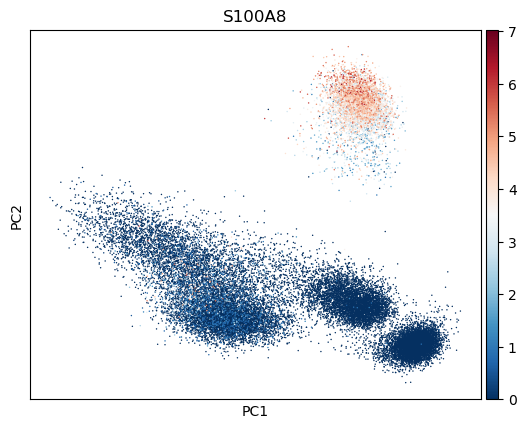

In [53]:
sc.pl.pca(adata_non_immune_hvg,color="S100A8",cmap="RdBu_r")

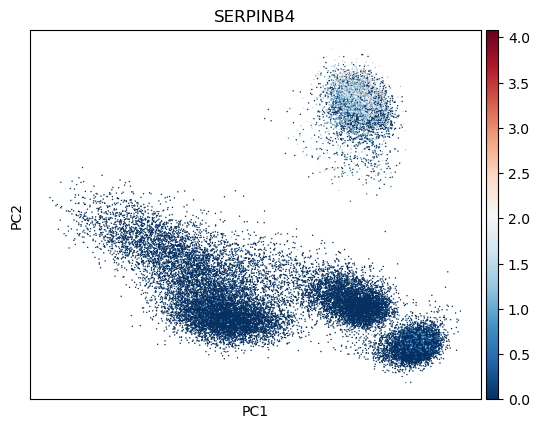

In [58]:

sc.pl.pca(adata_non_immune_hvg,color="SERPINB4",cmap="RdBu_r")

### Cluster 1 DEGs in SCVI

In [62]:
adata_non_immune.obs['cell_type']= 'None' 
adata_non_immune.obs.loc[(adata_non_immune.obs['leiden'] == '1') & (adata_non_immune.obs['Stage'] =='Ta'),'cell_type'] = 'cluster1_Ta'
adata_non_immune.obs.loc[(adata_non_immune.obs['leiden'] == '1') & (adata_non_immune.obs['Stage'] =='T2'),'cell_type'] = 'cluster1_T2'

In [67]:
cell_type_1 = "cluster1_Ta"
cell_idx1 = adata_non_immune.obs["cell_type"] == cell_type_1
print(sum(cell_idx1), "cells of type", cell_type_1)

cell_type_2 = "cluster1_T2"
cell_idx2 = adata_non_immune.obs["cell_type"] == cell_type_2
print(sum(cell_idx2), "cells of type", cell_type_2)

1653 cells of type cluster1_Ta
2872 cells of type cluster1_T2


In [135]:
adata_non_immune.obs["cell_type"] == cell_type_1

AAACCTGAGAAGAAGC.1-GSM4006644_BC1    False
AAACCTGAGCTACCTA.1-GSM4006644_BC1    False
AAACCTGCACGGCGTT.1-GSM4006644_BC1    False
AAACCTGCATCTCGCT.1-GSM4006644_BC1    False
AAACCTGTCAGGCCCA.1-GSM4006644_BC1     True
                                     ...  
TTTGTCAGTACAGACG.1-GSM4751268_BC7    False
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7    False
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7    False
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7     True
TTTGTCATCAACCATG.1-GSM4751268_BC7    False
Name: cell_type, Length: 27864, dtype: bool

In [134]:
adata_non_immune[adata_non_immune.obs["cell_type"] == cell_type_2]

View of AnnData object with n_obs × n_vars = 2872 × 2000
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden', 'Status', 'Stage', 'cell_type', '_scvi_raw_norm_scaling'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM47

In [136]:
indices = adata_non_immune[adata_non_immune.obs["cell_type"] == cell_type_2].obs.index


In [140]:
pd.Series(indices).to_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/index_cluster1T2.csv', index=False, header=False)

In [141]:
indices = adata_non_immune[adata_non_immune.obs["cell_type"] == cell_type_1].obs.index
pd.Series(indices).to_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/index_cluster1Ta.csv', index=False, header=False)


In [61]:
cell_idx1=adata_non_immune[(adata_non_immune.obs['leiden'] == '1') & (adata_non_immune.obs['Stage'] =='Ta'),]
cell_idx2 = adata_non_immune[(adata_non_immune.obs['leiden'] == '1') & (adata_non_immune.obs['Stage'] =='T2'),]
print(cell_idx1)
print(cell_idx2)

View of AnnData object with n_obs × n_vars = 1653 × 2000
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden', 'Status', 'Stage'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC

In [62]:
cell_idx2.index

Index(['AAACCTGAGAAGAAGC.1-GSM4006644_BC1',
       'AAACCTGAGCTACCTA.1-GSM4006644_BC1',
       'AAACCTGCACGGCGTT.1-GSM4006644_BC1',
       'AAACCTGCATCTCGCT.1-GSM4006644_BC1',
       'AAACCTGTCAGGCCCA.1-GSM4006644_BC1',
       'AAACCTGTCGGCGGTT.1-GSM4006644_BC1',
       'AAACGGGCAGGTCCAC.1-GSM4006644_BC1',
       'AAACGGGGTCATCGGC.1-GSM4006644_BC1',
       'AAACGGGTCACAATGC.1-GSM4006644_BC1',
       'AAACGGGTCTTGACGA.1-GSM4006644_BC1',
       ...
       'TTTGTCAAGTCAATAG.1-GSM4751268_BC7',
       'TTTGTCACAAAGAATC.1-GSM4751268_BC7',
       'TTTGTCACACAGGTTT.1-GSM4751268_BC7',
       'TTTGTCACAGATTGCT.1-GSM4751268_BC7',
       'TTTGTCACAGGACCCT.1-GSM4751268_BC7',
       'TTTGTCAGTACAGACG.1-GSM4751268_BC7',
       'TTTGTCAGTCTAGTCA.1-GSM4751268_BC7',
       'TTTGTCAGTGGCCCTA.1-GSM4751268_BC7',
       'TTTGTCAGTTCTGGTA.1-GSM4751268_BC7',
       'TTTGTCATCAACCATG.1-GSM4751268_BC7'],
      dtype='object', length=27864)

In [68]:
de_change = model.differential_expression(idx1=cell_idx1, idx2=cell_idx2)
de_change

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
Gene,,,,,,,,,,,,,,,,,,,
BISPR,1.0000,0.0000,18.420681,1.168522e-05,0.000001,0.0,0.25,3.169534,3.150770,0.792248,0.583208,6.533285,0.059891,0.002089,0.056261,0.002089,0.116165,0.012584,True
TCHH,1.0000,0.0000,18.420681,4.155950e-07,0.000122,0.0,0.25,-8.764510,-8.635952,1.652578,-14.291494,-3.261570,0.000000,0.189415,0.000000,0.159471,0.000000,1.146265,True
RAB9A,1.0000,0.0000,18.420681,7.705273e-05,0.000022,0.0,0.25,1.765272,1.730036,0.505040,0.346070,3.932712,0.393829,0.032730,0.303690,0.032382,0.737159,0.189300,True
SEL1L3,1.0000,0.0000,18.420681,4.370253e-05,0.000002,0.0,0.25,4.377050,4.302122,0.929002,1.232309,8.512502,0.234725,0.001741,0.186933,0.001741,0.444981,0.010616,True
FXYD5,1.0000,0.0000,18.420681,1.614312e-04,0.001098,0.0,0.25,-3.108583,-2.667263,1.212558,-7.189600,-1.193433,0.684815,1.880571,0.426497,0.807799,1.537956,10.897427,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTRHD1,0.4562,0.5438,-0.175650,3.143099e-04,0.000288,0.0,0.25,0.118639,0.141361,0.334433,-1.692998,1.568590,1.476104,0.480153,0.702359,0.366295,2.869209,2.798173,False
OST4,0.4444,0.5556,-0.223324,2.042314e-03,0.001910,0.0,0.25,0.076226,0.059260,0.339817,-1.307832,1.642748,11.042347,3.537604,0.995160,0.935237,21.109804,20.098379,False
SERP1,0.4316,0.5684,-0.275326,6.294203e-04,0.000579,0.0,0.25,0.107332,0.067909,0.341881,-0.754438,1.511804,3.298246,1.029944,0.895947,0.614903,6.241577,5.952508,False


In [69]:
de_change_uniform = model.differential_expression(
    idx1=cell_idx1,     
    idx2=cell_idx2,
    weights="uniform",
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_uniform["log10_pscore"] = np.log10(de_change_uniform["proba_not_de"])
de_change_uniform = de_change_uniform.join(adata_non_immune.var, how="inner")
de_change_uniform.head()

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Gene,,,,,,,,,,,,,,,,,,,,,
CXCL10,0.9190,0.0810,2.428837,0.000023,0.000022,0.0,0.25,-0.438583,-0.451446,2.478112,...,19,0.051240,99.655984,283,True,45.0,0.086743,2.882006,5.416957,5
PIGR,0.9126,0.0874,2.345802,0.000057,0.000019,0.0,0.25,0.418955,0.345807,2.377247,...,423,0.285352,92.341119,1576,True,104.0,0.158125,1.677612,5.337485,5
S100A8,0.9062,0.0938,2.268095,0.002998,0.003747,0.0,0.25,-0.356021,-0.349430,2.458537,...,22,0.022089,99.601666,122,True,23.0,5.358886,562.127594,9.605419,5
SERPINB3,0.9056,0.0944,2.261057,0.000100,0.000119,0.0,0.25,-0.214676,-0.179270,2.501855,...,57,0.019192,98.967952,106,True,72.0,0.229687,0.952374,3.728658,5
SAA2,0.9054,0.0946,2.258719,0.000003,0.000003,0.0,0.25,-0.058905,-0.102064,2.227539,...,6,0.006337,99.891363,35,True,393.5,0.035924,0.613108,2.725947,4


In [70]:
#importance might overkill. We used uniform upstairs instead
de_change_importance = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="importance",
    filter_outlier_cells=True,
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_importance["log10_pscore"] = np.log10(de_change_importance["proba_not_de"])
de_change_importance = de_change_importance.join(adata_non_immune.var, how="inner")

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [71]:
de_change_importance

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Gene,,,,,,,,,,,,,,,,,,,,,
COL6A1,1.0000,0.0000,18.420681,8.084458e-07,0.000005,0.0,0.25,-2.761241,-2.907125,1.279644,...,37,0.013036,99.330074,72,True,114.5,0.028747,0.167605,2.889143,4
DCN,1.0000,0.0000,18.420681,1.407614e-06,0.000007,0.0,0.25,-2.913106,-3.012342,1.396107,...,51,0.087452,99.076589,483,True,29.5,0.109999,3.624515,8.749196,4
TIMP2,1.0000,0.0000,18.420681,8.115731e-06,0.000010,0.0,0.25,-1.515215,-2.461418,1.513540,...,192,0.042549,96.523628,235,True,414.0,0.046045,0.098336,1.978217,4
RNASE1,1.0000,0.0000,18.420681,9.832542e-06,0.000024,0.0,0.25,-1.471078,-1.256083,0.920390,...,115,0.038204,97.917798,211,True,255.0,0.080067,0.256267,2.445765,5
MMP7,1.0000,0.0000,18.420681,3.544107e-05,0.000152,0.0,0.25,-2.477861,-2.841027,1.860468,...,224,0.061380,95.944233,339,True,168.0,0.340762,3.293165,3.956440,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHCHD2,0.2190,0.7810,-1.271503,1.164333e-03,0.001355,0.0,0.25,-0.258718,-0.169205,0.292580,...,5320,4.165490,3.675539,23006,True,163.0,6.856589,34.656890,0.892328,1
COMMD6,0.2190,0.7810,-1.271503,1.284235e-03,0.001407,0.0,0.25,-0.104301,-0.062000,0.296856,...,5494,7.944776,0.525077,43879,True,407.0,6.443260,27.284581,0.825300,1
COX4I1,0.2054,0.7946,-1.352880,2.585508e-03,0.002874,0.0,0.25,-0.202906,-0.113423,0.323666,...,5512,11.015209,0.199167,60837,True,601.0,12.785817,88.207363,0.874516,1


In [72]:
import plotnine as p9

In [74]:
de_comp = pd.concat(
    [
        de_change_importance.assign(flavor="importance"),
        de_change_uniform.assign(flavor="uniform"),
    ]
)

In [75]:
de_comp

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches,flavor
Gene,,,,,,,,,,,,,,,,,,,,,
COL6A1,1.0000,0.0000,18.420681,8.084458e-07,0.000005,0.0,0.25,-2.761241,-2.907125,1.279644,...,0.013036,99.330074,72,True,114.5,0.028747,0.167605,2.889143,4,importance
DCN,1.0000,0.0000,18.420681,1.407614e-06,0.000007,0.0,0.25,-2.913106,-3.012342,1.396107,...,0.087452,99.076589,483,True,29.5,0.109999,3.624515,8.749196,4,importance
TIMP2,1.0000,0.0000,18.420681,8.115731e-06,0.000010,0.0,0.25,-1.515215,-2.461418,1.513540,...,0.042549,96.523628,235,True,414.0,0.046045,0.098336,1.978217,4,importance
RNASE1,1.0000,0.0000,18.420681,9.832542e-06,0.000024,0.0,0.25,-1.471078,-1.256083,0.920390,...,0.038204,97.917798,211,True,255.0,0.080067,0.256267,2.445765,5,importance
MMP7,1.0000,0.0000,18.420681,3.544107e-05,0.000152,0.0,0.25,-2.477861,-2.841027,1.860468,...,0.061380,95.944233,339,True,168.0,0.340762,3.293165,3.956440,5,importance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATP5L,0.2838,0.7162,-0.925690,1.650814e-03,0.001680,0.0,0.25,-0.031516,-0.019009,0.258777,...,6.929205,1.122578,38270,True,973.0,8.265396,45.123655,0.855999,1,uniform
OST4,0.2778,0.7222,-0.955401,1.882853e-03,0.001895,0.0,0.25,-0.013570,-0.011588,0.242334,...,8.143762,0.488865,44978,True,387.0,9.207364,91.955348,1.203126,2,uniform
COX4I1,0.2380,0.7620,-1.163676,2.754548e-03,0.002784,0.0,0.25,-0.023060,-0.016343,0.247436,...,11.015209,0.199167,60837,True,601.0,12.785817,88.207363,0.874516,1,uniform


In [121]:
de_comp_importance = de_comp[de_comp['flavor']=='importance']
de_comp_importance

In [125]:
de_comp_importance= de_comp_importance[de_comp_importance['proba_not_de']<0.05]

In [126]:
de_comp_importance.to_pickle('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/blca_scR_scvi_t2_cluster1_DEG.xlsx')

In [79]:
de_comp["gene_type"] 


Gene
COL6A1    Other
DCN       Other
TIMP2     Other
RNASE1    Other
MMP7      Other
          ...  
ATP5L     Other
OST4      Other
COX4I1    Other
OAZ1      Other
FAU       Other
Name: gene_type, Length: 4000, dtype: object

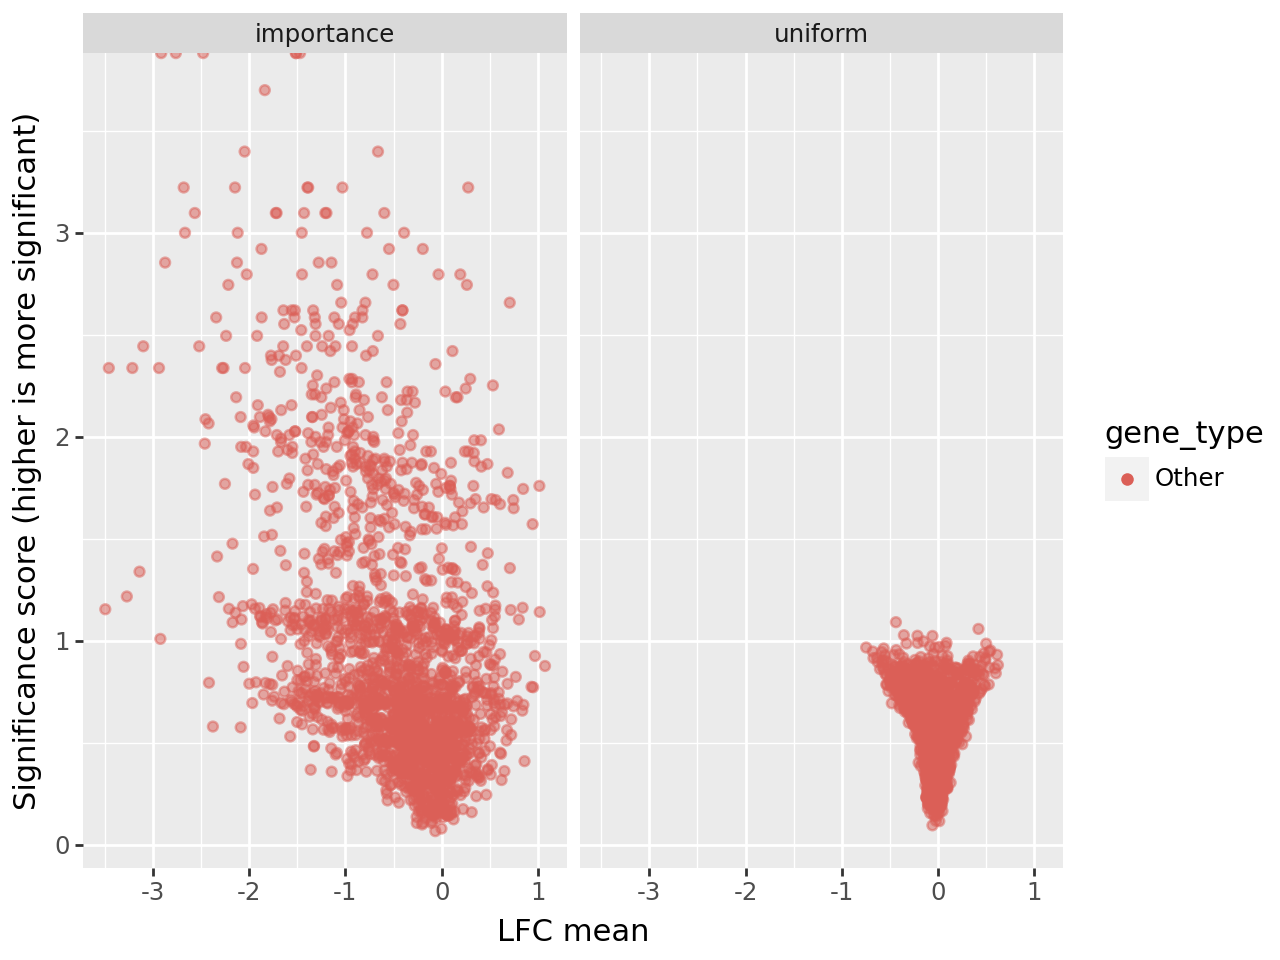

In [80]:
de_comp = pd.concat(
    [
        de_change_importance.assign(flavor="importance"),
        de_change_uniform.assign(flavor="uniform"),
    ]
)
de_comp["gene_type"] = "Other"
(
    p9.ggplot(de_comp, p9.aes("lfc_mean", "-log10_pscore", color="gene_type"))
    + p9.geom_point(
        de_comp.query("gene_type == 'Other'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.geom_point(de_comp.query("gene_type != 'Other'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    + p9.facet_wrap("flavor")
)


In [81]:
change_per_cluster_de = model.differential_expression(groupby="cell_type")

DE...:   0%|          | 0/3 [00:00<?, ?it/s]

In [82]:
cell_types = (
    adata_non_immune.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [85]:
cell_types

,n_cells,associated_test
cell_type,,
None,23339,None vs Rest
cluster1_T2,2872,cluster1_T2 vs Rest
cluster1_Ta,1653,cluster1_Ta vs Rest


In [112]:
marker_genes_full = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False)
    ))

/tmp/ipykernel_1043649/624023384.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [115]:
marker_genes_full.to_excel('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/blca_scR_scvi_DEG.xlsx')

In [128]:
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:20]
    ))

/tmp/ipykernel_1043649/2561407190.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [129]:
marker_genes

Gene  proba_de  proba_not_de  \
comparison                                                         
None vs Rest        111           SPINK1    0.9526        0.0474   
                    64            IGFBP5    0.9572        0.0428   
                    220           IGFBP2    0.9444        0.0556   
                    302             TESC    0.9400        0.0600   
                    210            DUSP2    0.9452        0.0548   
                    286           SPOCD1    0.9410        0.0590   
                    85             GDF15    0.9550        0.0450   
                    754             MEST    0.9118        0.0882   
                    569         C10orf99    0.9244        0.0756   
                    118            ADH1C    0.9506        0.0494   
                    156            GATA2    0.9480        0.0520   
                    24            TRIM31    0.9626        0.0374   
                    38             BNIP3    0.9602        0.0398   
                    84               FST    0.9550        0.0450   
                    74            IGFBP3    0.9562        0.0438   
                    73              CTSE    0.9566        0.0434   
                    253          SLC14A1    0.9428        0.0572   
                    214             QPRT    0.9446        0.0554   
                    100             MMP7    0.9540        0.0460   
                    76           TMPRSS2    0.9562        0.0438   
cluster1_T2 vs Rest 2003          S100A8    0.9882        0.0118   
                    2027            TCHH    0.9828        0.0172   
                    2005           LYNX1    0.9874        0.0126   
                    2016          S100A9    0.9842        0.0158   
                    2014        SERPINB4    0.9844        0.0156   
                    2002          KRTDAP    0.9888        0.0112   
                    2029        SERPINB3    0.9820        0.0180   
                    2037            CD36    0.9810        0.0190   
                    2123      AC018816.3    0.9736        0.0264   
                    2001           MMP12    0.9904        0.0096   
                    2075           CRIP1    0.9768        0.0232   
                    2021            MSR1    0.9838        0.0162   
                    2028           SPC24    0.9824        0.0176   
                    2091         C1orf56    0.9760        0.0240   
                    2019  WI2-85898F10.1    0.9842        0.0158   
                    2004           KRT14    0.9876        0.0124   
                    2493           TNNT3    0.9444        0.0556   
                    2036          CXCL10    0.9812        0.0188   
                    2273            IRX3    0.9610        0.0390   
                    2008          CALML3    0.9858        0.0142   
cluster1_Ta vs Rest 4001           UPK1A    0.9706        0.0294   
                    4011         EPB41L3    0.9616        0.0384   
                    4010           PHGR1    0.9616        0.0384   
                    4023          SPOCK1    0.9572        0.0428   
                    4205            SDC2    0.9368        0.0632   
                    4034           FABP4    0.9532        0.0468   
                    4021        APOBEC3A    0.9572        0.0428   
                    4834          IGFBP2    0.8958        0.1042   
                    4149          TRIM31    0.9404        0.0596   
                    4003            UPK2    0.9676        0.0324   
                    4068            LY6D    0.9478        0.0522   
                    4035           PRSS3    0.9532        0.0468   
                    4111            DLX5    0.9436        0.0564   
                    4164     RP11-11N9.4    0.9394        0.0606   
                    4147           CNGA1    0.9408        0.0592   
                    4016           UPK3A    0.9586        0.0414   
                    4096          FAM43A    0.9452        0.0548   
                    4159

In [99]:
adata_log = adata_non_immune[adata_non_immune.obs.cell_type.isin(cell_types.index.values)].copy()


In [105]:
adata_log

AnnData object with n_obs × n_vars = 27864 × 2000
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden', 'Status', 'Stage', 'cell_type', '_scvi_raw_norm_scaling'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_B

In [104]:
adata_log = adata_log[adata_log.obs['cell_type'].notna()].copy()


In [97]:
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)

In [107]:
adata_log.obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source,_scvi_batch,_scvi_labels,leiden,Status,Stage,cell_type,_scvi_raw_norm_scaling
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1,0,0,5,Ta,Ta,None,0.696913
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1,0,0,2,Ta,Ta,None,1.774308
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1,0,0,2,Ta,Ta,None,0.849762
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1,0,0,4,Ta,Ta,None,1.432460
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1,0,0,1,Ta,Ta,cluster1_Ta,1.034126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7,4,0,0,Ta,Ta,None,3.114295
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7,4,0,0,Ta,Ta,None,4.514673
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7,4,0,2,Ta,Ta,None,0.958497
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7,4,0,1,Ta,Ta,cluster1_Ta,1.938736


In [110]:
marker_genes['Gene']

comparison               
None vs Rest         111         SPINK1
                     64          IGFBP5
                     220         IGFBP2
                     302           TESC
                     210          DUSP2
                     286         SPOCD1
                     85           GDF15
                     754           MEST
                     569       C10orf99
                     118          ADH1C
cluster1_T2 vs Rest  2003        S100A8
                     2027          TCHH
                     2005         LYNX1
                     2016        S100A9
                     2014      SERPINB4
                     2002        KRTDAP
                     2029      SERPINB3
                     2037          CD36
                     2123    AC018816.3
                     2001         MMP12
cluster1_Ta vs Rest  4001         UPK1A
                     4011       EPB41L3
                     4010         PHGR1
                     4023        SPOCK1
              

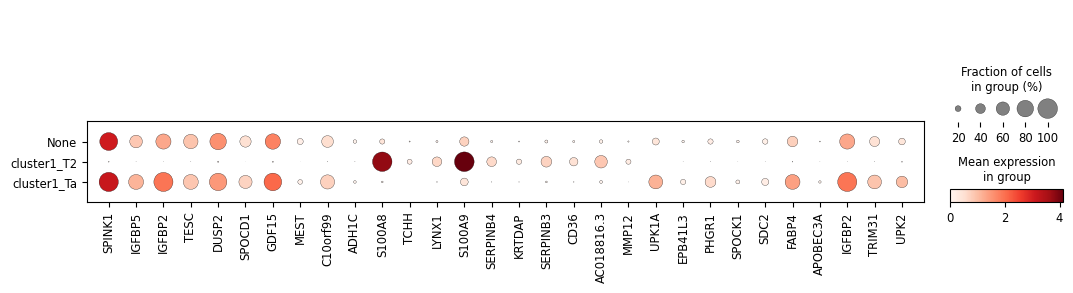

In [111]:
sc.pl.dotplot(adata_log, marker_genes['Gene'],groupby='cell_type')

### Cluster 3 

In [142]:
cell_idx3=adata_non_immune[(adata_non_immune.obs['leiden'] == '3') & (adata_non_immune.obs['Stage'] =='Ta'),]
cell_idx4 = adata_non_immune[(adata_non_immune.obs['leiden'] == '3') & (adata_non_immune.obs['Stage'] =='T2'),]
print(cell_idx3)
print(cell_idx4)

View of AnnData object with n_obs × n_vars = 643 × 2000
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden', 'Status', 'Stage', 'cell_type', '_scvi_raw_norm_scaling'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM475

In [155]:
adata_non_immune.obs.loc[(adata_non_immune.obs['leiden'] == '3') & (adata_non_immune.obs['Stage'] =='Ta'),'cell_type'] = 'cluster3_Ta'
adata_non_immune.obs.loc[(adata_non_immune.obs['leiden'] == '3') & (adata_non_immune.obs['Stage'] =='T2'),'cell_type'] = 'cluster3_T2'

In [159]:
cell_type_3 = "cluster3_Ta"
cell_idx3 = adata_non_immune.obs["cell_type"] == cell_type_3
print(sum(cell_idx1), "cells of type", cell_type_3)

cell_type_4 = "cluster3_T2"
cell_idx4 = adata_non_immune.obs["cell_type"] == cell_type_4
print(sum(cell_idx4), "cells of type", cell_type_4)

1653 cells of type cluster3_Ta
1770 cells of type cluster3_T2


In [160]:
de_change_1 = model.differential_expression(idx1=cell_idx3, idx2=cell_idx4)
de_change_1

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
Gene,,,,,,,,,,,,,,,,,,,
BISPR,1.0000,0.0000,18.420681,0.000013,1.193597e-06,0.0,0.25,3.405494,3.398429,0.824639,0.528364,6.416941,0.135303,0.003390,0.121306,0.003390,0.121741,0.013589,True
TMPRSS2,1.0000,0.0000,18.420681,0.000067,9.156020e-07,0.0,0.25,5.867883,6.126997,1.342927,1.939186,9.165755,0.724728,0.001695,0.424572,0.001695,0.642542,0.005500,True
TRIM31,1.0000,0.0000,18.420681,0.000533,1.452030e-06,0.0,0.25,7.943455,8.207678,1.726129,2.842966,12.569842,6.706065,0.002260,0.738725,0.002260,6.265802,0.009572,True
FXYD5,1.0000,0.0000,18.420681,0.000102,1.044384e-03,0.0,0.25,-3.817984,-3.940645,1.229939,-6.886947,-0.699555,0.911353,2.688701,0.466563,0.853107,1.000807,10.432692,True
TESC,1.0000,0.0000,18.420681,0.000303,2.690360e-06,0.0,0.25,6.505989,6.698470,1.307302,0.908838,10.373412,3.009331,0.007910,0.730949,0.007345,2.936285,0.028638,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMDT1,0.5392,0.4608,0.157122,0.000531,4.676982e-04,0.0,0.25,0.171032,0.177429,0.350529,-1.386543,1.482816,5.570762,1.328814,0.956454,0.636723,5.255036,4.807528,False
TMEM256,0.4930,0.5070,-0.028002,0.000386,3.497998e-04,0.0,0.25,0.110694,0.061268,0.400082,-1.393821,1.507218,3.922240,0.940113,0.897356,0.529944,3.636383,3.393354,False
HDDC2,0.4926,0.5074,-0.029602,0.000139,1.413472e-04,0.0,0.25,-0.044272,-0.024540,0.392098,-2.039210,1.259071,1.463453,0.384181,0.681182,0.277401,1.384801,1.390067,False


In [163]:
de_change_uniform_1 = model.differential_expression(
    idx1=cell_idx3,     
    idx2=cell_idx4,
    weights="uniform",
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_uniform_1["log10_pscore"] = np.log10(de_change_uniform_1["proba_not_de"])
de_change_uniform_1 = de_change_uniform_1.join(adata_non_immune.var, how="inner")
de_change_uniform_1.head()

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Gene,,,,,,,,,,,,,,,,,,,,,
RRM2,0.9326,0.0674,2.627331,0.000183,0.000050,0.0,0.25,1.231504,0.929003,2.911487,...,10,0.003621,99.818939,20,True,154.0,0.125431,0.510951,2.749263,5
CDK1,0.9244,0.0756,2.503688,0.000188,0.000046,0.0,0.25,1.149445,0.790587,2.864248,...,11,0.004345,99.800833,24,True,223.0,0.122560,0.935594,3.788990,5
KIAA0101,0.9224,0.0776,2.475411,0.000674,0.000238,0.0,0.25,1.025624,0.833150,2.509527,...,102,0.024986,98.153178,138,True,82.0,0.610932,5.578477,4.567780,5
BIRC5,0.9220,0.0780,2.469836,0.000162,0.000064,0.0,0.25,0.989561,0.681537,2.735212,...,12,0.002535,99.782727,14,True,173.0,0.149584,0.590910,2.480852,5
CDKN3,0.9212,0.0788,2.458764,0.000111,0.000039,0.0,0.25,1.044433,0.789001,2.696774,...,9,0.002173,99.837045,12,True,148.0,0.108958,0.418591,2.527335,5


In [161]:
#importance might overkill. We used uniform upstairs instead
de_change_importance_1 = model.differential_expression(
    idx1=cell_idx3,  # we use the same cells as chosen before
    idx2=cell_idx4,
    weights="importance",
    filter_outlier_cells=True,
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_importance_1["log10_pscore"] = np.log10(de_change_importance_1["proba_not_de"])
de_change_importance_1= de_change_importance_1.join(adata_non_immune.var, how="inner")

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

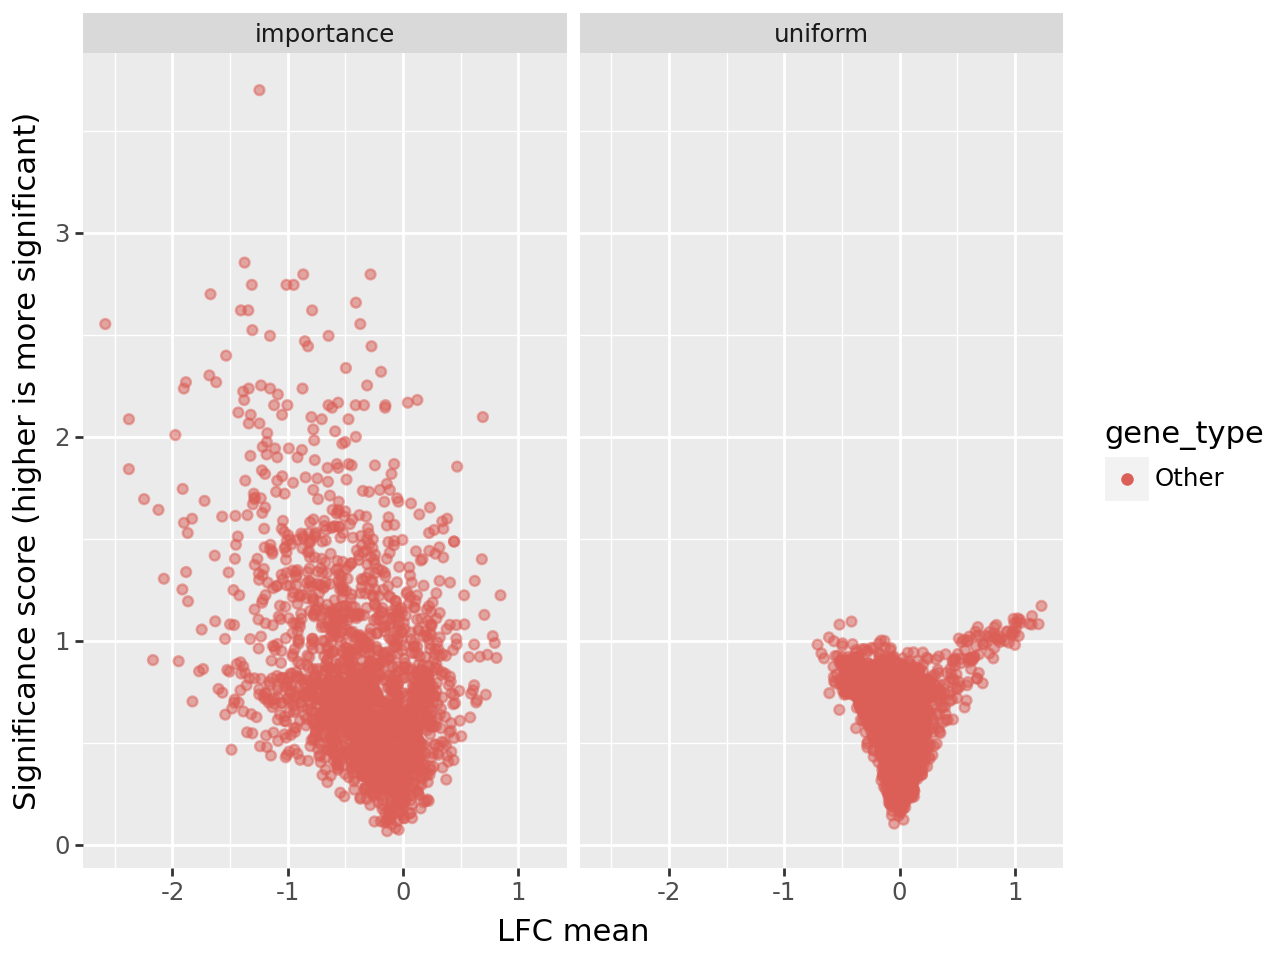

In [164]:
de_comp_1 = pd.concat(
    [
        de_change_importance_1.assign(flavor="importance"),
        de_change_uniform_1.assign(flavor="uniform"),
    ]
)
de_comp_1["gene_type"] = "Other"
(
    p9.ggplot(de_comp_1, p9.aes("lfc_mean", "-log10_pscore", color="gene_type"))
    + p9.geom_point(
        de_comp_1.query("gene_type == 'Other'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.geom_point(de_comp_1.query("gene_type != 'Other'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    + p9.facet_wrap("flavor")
)


In [165]:
change_per_cluster_de_1 = model.differential_expression(groupby="cell_type")

DE...:   0%|          | 0/5 [00:00<?, ?it/s]

In [170]:
cell_types = (
    adata_non_immune.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [171]:
marker_genes_full_1 = (
    change_per_cluster_de_1.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False)
    ))

/tmp/ipykernel_1043649/2240323589.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [174]:
set(marker_genes_full_1['comparison'])

{'None vs Rest',
 'cluster1_T2 vs Rest',
 'cluster1_Ta vs Rest',
 'cluster3_T2 vs Rest',
 'cluster3_Ta vs Rest'}

In [176]:
marker_genes_full_1[marker_genes_full_1['comparison'] =='cluster3_T2 vs Rest']

Gene  proba_de  proba_not_de  bayes_factor  \
comparison                                                                 
cluster3_T2 vs Rest 6005    S100A8    0.9838        0.0162      4.106411   
                    6055      TCHH    0.9746        0.0254      3.647278   
                    6036     LYNX1    0.9770        0.0230      3.748992   
                    6018  SERPINB4    0.9802        0.0198      3.902074   
                    6002    KRTDAP    0.9864        0.0136      4.283991   
...                            ...       ...           ...           ...   
                    6041    TRIM31    0.9760        0.0240      3.705408   
                    6129      TESC    0.9656        0.0344      3.334693   
                    6057    IGFBP2    0.9742        0.0258      3.631242   
                    6039    IGFBP5    0.9762        0.0238      3.713981   
                    6001    SPINK1    0.9864        0.0136      4.283991   

                            scale1    scale2  pseudocounts  delta  lfc_mean  \
comparison                                                                    
cluster3_T2 vs Rest 6005  0.010801  0.002341           0.0   0.25  9.952347   
                    6055  0.000109  0.000016           0.0   0.25  7.817023   
                    6036  0.000433  0.000068           0.0   0.25  7.238245   
                    6018  0.000327  0.000059           0.0   0.25  6.948934   
                    6002  0.000202  0.000033           0.0   0.25  6.676867   
...                            ...       ...           ...    ...       ...   
                    6041  0.000001  0.000244           0.0   0.25 -6.078705   
                    6129  0.000003  0.000469           0.0   0.25 -6.369891   
                    6057  0.000004  0.001022           0.0   0.25 -6.542513   
                    6039  0.000002  0.000644           0.0   0.25 -7.186112   
                    6001  0.000012  0.008602           0.0   0.25 -8.350103   

                          lfc_median  ...  raw_mean1  raw_mean2  \
comparison                            ...                         
cluster3_T2 vs Rest 6005    9.818516  ...  21.864407   4.239289   
                    6055    8.785172  ...   0.267797   0.027708   
                    6036    8.020990  ...   0.949153   0.116579   
                    6018    7.559398  ...   0.728249   0.119568   
                    6002    7.292338  ...   0.381921   0.074308   
...                              ...  ...        ...        ...   
                    6041   -6.573865  ...   0.002260   1.569518   
                    6129   -7.271789  ...   0.007910   2.282900   
                    6057   -7.634114  ...   0.003955   5.305626   
                    6039   -7.971070  ...   0.001130   3.646317   
                    6001   -9.464225  ...   0.022599  42.084770   

                          non_zeros_proportion1  non_zeros_proportion2  \
comparison                                                               
cluster3_T2 vs Rest 6005               0.989266               0.195754   
                    6055               0.206215               0.022266   
                    6036               0.484181               0.055453   
                    6018               0.414689               0.062237   
                    6002               0.177401               0.024527   
...                                         ...                    ...   
                    6041               0.002260               0.408523   
                    6129               0.007345               0.637694   
                    6057               0.003955               0.693378   
                    6039               0.001130               0.542500   
                    6001               0.020339               0.852188   

                          raw_normalized_mean1  raw_normalized_mean2  \
comparison                                                             
cluster3_T2 vs Rest 6005          

In [167]:
(
    change_per_cluster_de_1.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:20]
    ))

/tmp/ipykernel_1043649/1905003990.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Gene  proba_de  proba_not_de  \
comparison                                                         
None vs Rest        95            SPINK1    0.9640        0.0360   
                    67            IGFBP5    0.9670        0.0330   
                    184             TESC    0.9570        0.0430   
                    219           IGFBP2    0.9548        0.0452   
                    104            DUSP2    0.9630        0.0370   
                    73             GDF15    0.9662        0.0338   
                    176           SPOCD1    0.9576        0.0424   
                    14            TRIM31    0.9750        0.0250   
                    472         C10orf99    0.9392        0.0608   
                    127            GATA2    0.9612        0.0388   
                    622             MEST    0.9300        0.0700   
                    309          SLC14A1    0.9490        0.0510   
                    212             QPRT    0.9556        0.0444   
                    75             BNIP3    0.9660        0.0340   
                    133           IGFBP3    0.9606        0.0394   
                    56              MMP7    0.9676        0.0324   
                    155            ADH1C    0.9590        0.0410   
                    115            UPK3A    0.9622        0.0378   
                    112             CTSE    0.9624        0.0376   
                    90               FST    0.9644        0.0356   
cluster1_T2 vs Rest 2005          S100A8    0.9868        0.0132   
                    2031            TCHH    0.9810        0.0190   
                    2006           LYNX1    0.9866        0.0134   
                    2019          S100A9    0.9826        0.0174   
                    2002        SERPINB4    0.9880        0.0120   
                    2000          KRTDAP    0.9908        0.0092   
                    2048        SERPINB3    0.9780        0.0220   
                    2093            CD36    0.9742        0.0258   
                    2143      AC018816.3    0.9696        0.0304   
                    2004           MMP12    0.9868        0.0132   
                    2119           CRIP1    0.9720        0.0280   
                    2014            MSR1    0.9836        0.0164   
                    2091         C1orf56    0.9746        0.0254   
                    2030           SPC24    0.9812        0.0188   
                    2016  WI2-85898F10.1    0.9832        0.0168   
                    2003           KRT14    0.9872        0.0128   
                    2534           TNNT3    0.9382        0.0618   
                    2348            IRX3    0.9528        0.0472   
                    2032          CXCL10    0.9806        0.0194   
                    2049            IGKC    0.9780        0.0220   
cluster1_Ta vs Rest 4006           UPK1A    0.9670        0.0330   
                    4011         EPB41L3    0.9612        0.0388   
                    4025          SPOCK1    0.9570        0.0430   
                    4023           PHGR1    0.9574        0.0426   
                    4199            SDC2    0.9372        0.0628   
                    4026           FABP4    0.9568        0.0432   
                    4736          IGFBP2    0.9028        0.0972   
                    4169          TRIM31    0.9402        0.0598   
                    4035        APOBEC3A    0.9556        0.0444   
                    4004            UPK2    0.9670        0.0330   
                    4117     RP11-11N9.4    0.9448        0.0552   
                    4064            DLX5    0.9494        0.0506   
                    4177           CNGA1    0.9394        0.0606   
                    4037           PRSS3    0.9548        0.0452   
                    4137            LY6D    0.9436        0.0564   
                    4109         PLA2G2A    0.9456        0.0544   
                    4069          FAM43A    0.9490        0.0510   
                    4028

In [177]:
marker_genes_full_1.to_excel('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/blca_scR_scvi_DEG_1.xlsx')